# Single transmon qubit characterization

The experiments of this tutorial are meant to be executed with a Qblox Cluster controlling a transmon system.

The experiments can also be executed using a dummy Qblox device that is created via an instance of the `Cluster` class, and is initialized with a dummy configuration.

However, when using a dummy device, the analysis will not work because the experiments will return `np.nan` values.

When using this notebook together with a dummy device, example data is loaded from the `"./example_data/"` directory.

## Setup
In this section we configure the hardware configuration which specifies the connectivity of our system.

### Configuration file

This is a template hardware configuration file for a 1-qubit system with a flux-control line which can be used to tune the qubit frequency.

The hardware setup is as follows, by cluster slot:
- **QCM-RF** (Slot 6)
  - Drive line for `qubit` using fixed 80 MHz IF.
- **QCM** (Slot 2)
  - Flux line for `qubit`.
- **QRM-RF** (Slot 8)
  - Readout line for `qubit` using a fixed LO set at 7.5 GHz.

Note that in the hardware configuration below the mixers are uncorrected, but for high fidelity experiments this should also be done for all the modules.

In [1]:
from __future__ import annotations

hardware_cfg = {
    "backend": "quantify_scheduler.backends.qblox_backend.hardware_compile",
    "cluster0": {
        "sequence_to_file": False,  # Boolean flag which dumps waveforms and program dict to JSON file
        "ref": "internal",  # Use shared clock reference of the cluster
        "instrument_type": "Cluster",
        # ============ DRIVE ============#
        "cluster0_module6": {
            "instrument_type": "QCM_RF",
            "complex_output_0": {
                "output_att": 0,
                "dc_mixer_offset_I": 0.0,
                "dc_mixer_offset_Q": 0.0,
                "portclock_configs": [
                    {
                        "port": "qubit:mw",
                        "clock": "qubit.01",
                        "interm_freq": 80e6,
                        "mixer_amp_ratio": 1.0,
                        "mixer_phase_error_deg": 0.0,
                    }
                ],
            },
        },
        # ============ FLUX ============#
        "cluster0_module2": {
            "instrument_type": "QCM",
            "real_output_0": {"portclock_configs": [{"port": "qubit:fl", "clock": "cl0.baseband"}]},
        },
        # ============ READOUT ============#
        "cluster0_module8": {
            "instrument_type": "QRM_RF",
            "complex_output_0": {
                "output_att": 0,
                "input_att": 0,
                "dc_mixer_offset_I": 0.0,
                "dc_mixer_offset_Q": 0.0,
                "lo_freq": 7.5e9,
                "portclock_configs": [
                    {
                        "port": "qubit:res",
                        "clock": "qubit.ro",
                        "mixer_amp_ratio": 1.0,
                        "mixer_phase_error_deg": 0.0,
                    }
                ],
            },
        },
    },
}

In [2]:
from pathlib import Path

import numpy as np
from qcodes.instrument import find_or_create_instrument
from qcodes.parameters import ManualParameter

import quantify_core.data.handling as dh
from qblox_instruments import Cluster, ClusterType
from quantify_core.analysis.single_qubit_timedomain import RabiAnalysis, RamseyAnalysis, T1Analysis
from quantify_core.analysis.spectroscopy_analysis import (
    QubitFluxSpectroscopyAnalysis,
    QubitSpectroscopyAnalysis,
    ResonatorFluxSpectroscopyAnalysis,
)
from quantify_core.measurement.control import MeasurementControl
from quantify_core.visualization.pyqt_plotmon import PlotMonitor_pyqt as PlotMonitor
from quantify_scheduler.device_under_test.quantum_device import QuantumDevice
from quantify_scheduler.device_under_test.transmon_element import BasicTransmonElement
from quantify_scheduler.gettables import ScheduleGettable
from quantify_scheduler.instrument_coordinator import InstrumentCoordinator
from quantify_scheduler.instrument_coordinator.components.qblox import ClusterComponent
from quantify_scheduler.operations.gate_library import Measure, Reset
from quantify_scheduler.operations.pulse_library import SetClockFrequency, SquarePulse
from quantify_scheduler.resources import ClockResource
from quantify_scheduler.schedules import heterodyne_spec_sched_nco, rabi_sched, t1_sched
from quantify_scheduler.schedules.schedule import Schedule
from quantify_scheduler.schedules.timedomain_schedules import ramsey_sched

### Scan For Clusters

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/api_reference/tools.html#api-pnp) for more info).

In [3]:
!qblox-pnp list

No devices found


In [4]:
cluster_ip = None  # To run this tutorial on hardware, fill in the IP address of the cluster here
cluster_name = "cluster0"

### Connect to Cluster

We now make a connection with the Cluster.

In [5]:
cluster = find_or_create_instrument(
    Cluster,
    recreate=True,
    name=cluster_name,
    identifier=cluster_ip,
    dummy_cfg=(
        {
            2: ClusterType.CLUSTER_QCM,
            4: ClusterType.CLUSTER_QRM,
            6: ClusterType.CLUSTER_QCM_RF,
            8: ClusterType.CLUSTER_QRM_RF,
        }
        if cluster_ip is None
        else None
    ),
)

### Reset the Cluster

We reset the Cluster to enter a well-defined state. Note that resetting will clear all stored parameters and repeats startup calibration, so resetting between experiments is usually not desirable.

In [6]:
cluster.reset()
print(cluster.get_system_state())

Status: CRITICAL, Flags: TEMPERATURE_OUT_OF_RANGE, Slot flags: SLOT2_TEMPERATURE_OUT_OF_RANGE, SLOT4_TEMPERATURE_OUT_OF_RANGE, SLOT6_TEMPERATURE_OUT_OF_RANGE, SLOT8_TEMPERATURE_OUT_OF_RANGE


Note that a dummy cluster will raise error flags, this is expected behavior and can be ignored.

### Quantum device settings
Here we initialize our `QuantumDevice` and our qubit parameters,  checkout this [tutorial](https://quantify-os.org/docs/quantify-scheduler/tutorials/Operations%20and%20Qubits.html) for further details.

In short, a `QuantumDevice` contains device elements where we save our found parameters.

In [7]:
qubit = find_or_create_instrument(BasicTransmonElement, recreate=True, name="qubit")
qubit.measure.acq_channel(0)

quantum_device = find_or_create_instrument(QuantumDevice, recreate=True, name="device_1q")
quantum_device.hardware_config(hardware_cfg)
quantum_device.add_element(qubit)

### Configure measurement control loop
We will use a `MeasurementControl` object for data acquisition as well as an `InstrumentCoordinator` for controlling the instruments in our setup.

The `PlotMonitor` is used for live plotting.

All of these are then associated with the `QuantumDevice`.

In [8]:
def configure_measurement_control_loop(
    device: QuantumDevice, cluster: Cluster, live_plotting: bool = False
) -> tuple[MeasurementControl, InstrumentCoordinator]:
    meas_ctrl = find_or_create_instrument(MeasurementControl, recreate=True, name="meas_ctrl")
    ic = find_or_create_instrument(InstrumentCoordinator, recreate=True, name="ic")

    # Add cluster to instrument coordinator
    ic_cluster = ClusterComponent(cluster)
    ic.add_component(ic_cluster)

    if live_plotting:
        # Associate plot monitor with measurement controller
        plotmon = find_or_create_instrument(PlotMonitor, recreate=False, name="PlotMonitor")
        meas_ctrl.instr_plotmon(plotmon.name)

    # Associate measurement controller and instrument coordinator with the quantum device
    device.instr_measurement_control(meas_ctrl.name)
    device.instr_instrument_coordinator(ic.name)

    return (meas_ctrl, ic)


meas_ctrl, instrument_coordinator = configure_measurement_control_loop(quantum_device, cluster)

### Set data directory
This directory is where all of the experimental data as well as all of the post processing will go.

In [9]:
# Enter your own dataset directory here!
dh.set_datadir(Path("example_data").resolve())

### Configure external flux control
In the case of flux-tunable transmon qubits, we need to have some way of controlling the external flux.

This can be done by setting an output bias on a module of the cluster which is then connected to the flux line.

If your system is not using flux-tunable transmons, then you can skip to the next section.

In [10]:
flux_settable: callable = cluster.module2.out0_offset
flux_settable.inter_delay = 100e-9  # Delay time in seconds between consecutive set operations.
flux_settable.step = 0.3e-3  # Stepsize in V that this Parameter uses during set operation.
flux_settable(0.0)

### Activate NCO delay compensation
Compensate for the digital propagation delay for each qubit (i.e each sequencer)

For more info, please see the [API reference](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/api_reference/sequencer.html#Sequencer.nco_prop_delay_comp).

To avoid mismatches between modulation and demodulation, the delay between any readout frequency or phase changes and the next acquisition should be equal or greater than the total propagation delay (146ns + user defined value).

In [11]:
for i in range(6):
    getattr(cluster.module8, f"sequencer{i}").nco_prop_delay_comp_en(True)
    getattr(cluster.module8, f"sequencer{i}").nco_prop_delay_comp(50)

## Characterization experiments
The sweep setpoints for all experiments (e.g. `frequency_setpoints` in the spectroscopy experiments) are only examples. The sweep setpoints should be changed to match your own system.

We show two sets of experiments: The first contains generic characterization experiments for transmon qubits. The second contains 2D experiments for finding the flux sweetspot, applicable for flux-tunable qubits.

Here we consider five standard characterization experiments for single qubit tuneup. The experiments are:
1. Resonator spectroscopy
    - Used to find the frequency response of the readout resonator when the qubit is in $|0\rangle$.
2. Qubit spectroscopy (a.k.a two-tone)
    - Used to find the $|0\rangle \rightarrow |1\rangle$ drive frequency.
3. Rabi oscillations
    - Used to find precise excitation pulse required to excite the qubit to $|1\rangle$.
4. Ramsey oscillations
    - Used to tune the $|0\rangle \rightarrow |1\rangle$ drive frequency more precisely.
    - Used to measure $T_2^*$.
5. T1
    - Used to find the time it takes for the qubit to decay from $|1\rangle$ to $|0\rangle$, the $T_1$ time.

## Resonator spectroscopy

In [12]:
freq = ManualParameter(name="freq", unit="Hz", label="Frequency")
freq.batched = True
freq.batch_size = 100

spec_sched_kwargs = dict(
    pulse_amp=1 / 6,
    pulse_duration=2e-6,
    frequencies=freq,
    acquisition_delay=196e-9,
    integration_time=2e-6,
    init_duration=10e-6,
    port=qubit.ports.readout(),
    clock=qubit.name + ".ro",
)
gettable = ScheduleGettable(
    quantum_device,
    schedule_function=heterodyne_spec_sched_nco,
    schedule_kwargs=spec_sched_kwargs,
    real_imag=False,
    batched=True,
)

meas_ctrl.gettables(gettable)

In [13]:

quantum_device.cfg_sched_repetitions(400)

center = 7.7e9
frequency_setpoints = np.linspace(center - 20e6, center + 20e6, 300)
meas_ctrl.settables(freq)
meas_ctrl.setpoints(frequency_setpoints)

rs_ds = meas_ctrl.run("resonator spectroscopy")
rs_ds

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 freq 
Batch size limit: 100



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

<xarray.Dataset>
Dimensions:  (dim_0: 300)
Coordinates:
    x0       (dim_0) float64 7.68e+09 7.68e+09 7.68e+09 ... 7.72e+09 7.72e+09
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    y1       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    tuid:                             20240422-183616-460-6bdb16
    name:                             resonator spectroscopy
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

In [14]:
# If on dummy, override with old data for analysis
if cluster_ip is None:
    rs_ds = dh.load_dataset(tuid="20230509-100918-578-4f26b5")

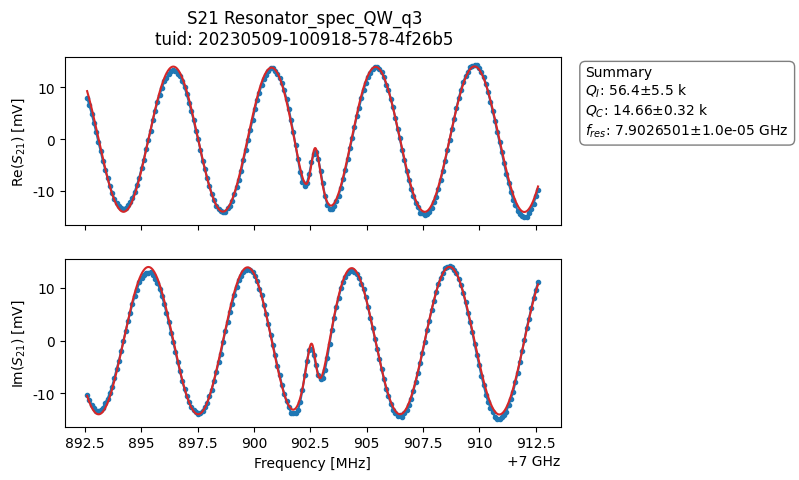

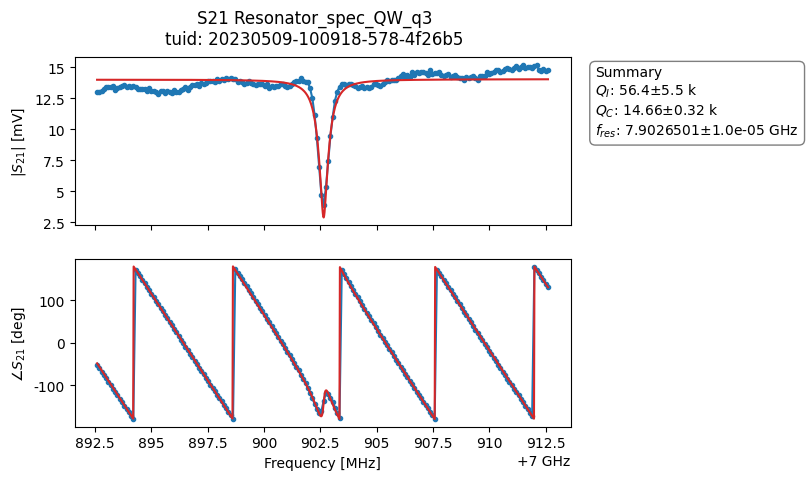

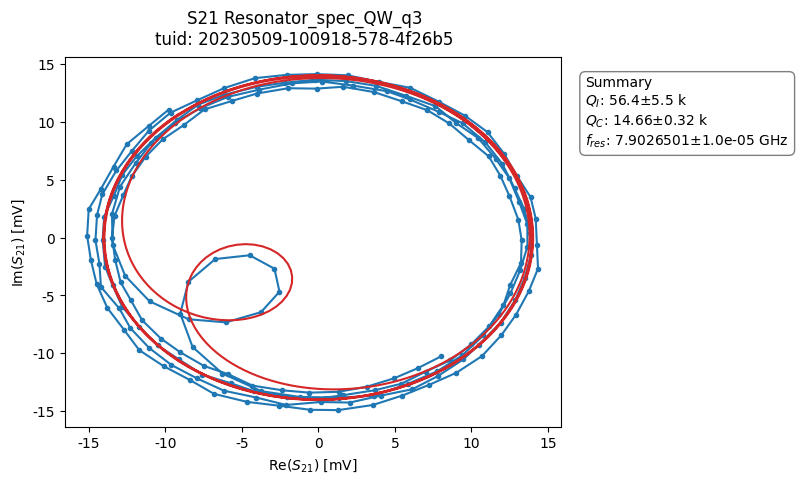

In [15]:
from quantify_core.analysis.spectroscopy_analysis import ResonatorSpectroscopyAnalysis

rs_analysis = ResonatorSpectroscopyAnalysis(tuid=rs_ds.attrs["tuid"], dataset=rs_ds)
rs_analysis.run().display_figs_mpl()

In [16]:
qubit.reset.duration(100e-6)
qubit.measure.acq_delay(spec_sched_kwargs["acquisition_delay"])
qubit.measure.pulse_amp(spec_sched_kwargs["pulse_amp"])
qubit.measure.pulse_duration(spec_sched_kwargs["pulse_duration"])
qubit.measure.integration_time(spec_sched_kwargs["integration_time"])

qubit.clock_freqs.readout(rs_analysis.quantities_of_interest["fr"].nominal_value)

## Resonator punchout

In [17]:
freq = ManualParameter(name="freq", unit="Hz", label="Frequency")
freq.batched = True

ro_pulse_amp = ManualParameter(name="ro_pulse_amp", unit="", label="Readout pulse amplitude")
ro_pulse_amp.batched = False

spec_sched_kwargs = dict(
    pulse_amp=ro_pulse_amp,
    pulse_duration=2e-6,
    frequencies=freq,
    acquisition_delay=196e-9,
    integration_time=2e-6,
    init_duration=10e-6,
    port=qubit.ports.readout(),
    clock=qubit.name + ".ro",
)
gettable = ScheduleGettable(
    quantum_device,
    schedule_function=heterodyne_spec_sched_nco,
    schedule_kwargs=spec_sched_kwargs,
    real_imag=False,
    batched=True,
)

meas_ctrl.gettables(gettable)

In [18]:

quantum_device.cfg_sched_repetitions(80)
center = 7.7e9
frequency_setpoints = np.linspace(center - 20e6, center + 20e6, 300)

meas_ctrl.settables([freq, ro_pulse_amp])
meas_ctrl.setpoints_grid((frequency_setpoints, np.linspace(0, 1, 10)))

punchout_ds = meas_ctrl.run("resonator punchout")
punchout_ds

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 ro_pulse_amp 
Batched settable(s):
	 freq 
Batch size limit: 1024



c:\Users\axela\miniconda3\envs\aps\lib\site-packages\quantify_scheduler\backends\circuit_to_device.py:379: RuntimeWarning: Clock 'qubit.ro' has conflicting frequency definitions: 7680000000.0 Hz in the schedule and 7902650075.61745 Hz in the device config. The clock is set to '7680000000.0'. Ensure the schedule clock resource matches the device config clock frequency or set the clock frequency in the device config to np.NaN to omit this warning.
  warnings.warn(


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

c:\Users\axela\miniconda3\envs\aps\lib\site-packages\quantify_scheduler\backends\circuit_to_device.py:379: RuntimeWarning: Clock 'qubit.ro' has conflicting frequency definitions: 7680000000.0 Hz in the schedule and 7902650075.61745 Hz in the device config. The clock is set to '7680000000.0'. Ensure the schedule clock resource matches the device config clock frequency or set the clock frequency in the device config to np.NaN to omit this warning.
  warnings.warn(
c:\Users\axela\miniconda3\envs\aps\lib\site-packages\quantify_scheduler\backends\circuit_to_device.py:379: RuntimeWarning: Clock 'qubit.ro' has conflicting frequency definitions: 7680000000.0 Hz in the schedule and 7902650075.61745 Hz in the device config. The clock is set to '7680000000.0'. Ensure the schedule clock resource matches the device config clock frequency or set the clock frequency in the device config to np.NaN to omit this warning.
  warnings.warn(
c:\Users\axela\miniconda3\envs\aps\lib\site-packages\quantify_sche

<xarray.Dataset>
Dimensions:  (dim_0: 3000)
Coordinates:
    x0       (dim_0) float64 7.68e+09 7.68e+09 7.68e+09 ... 7.72e+09 7.72e+09
    x1       (dim_0) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    y1       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    tuid:                             20240422-183619-602-65688e
    name:                             resonator punchout
    grid_2d:                          True
    grid_2d_uniformly_spaced:         True
    1d_2_settables_uniformly_spaced:  False
    xlen:                             300
    ylen:                             10

In [19]:
# If on dummy, override with old data for analysis
if cluster_ip is None:
    punchout_ds = dh.load_dataset(tuid="20230309-234016-313-799418")

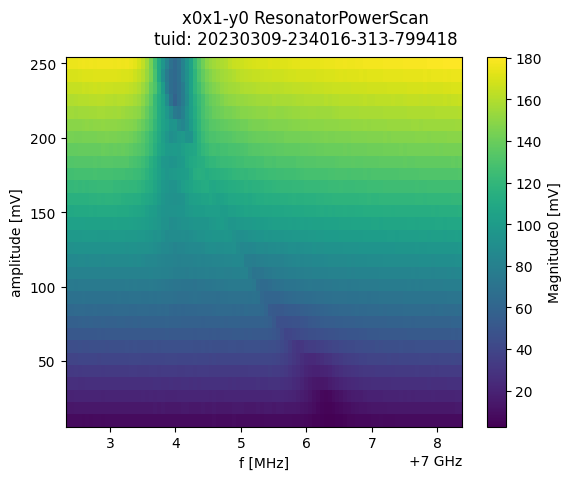

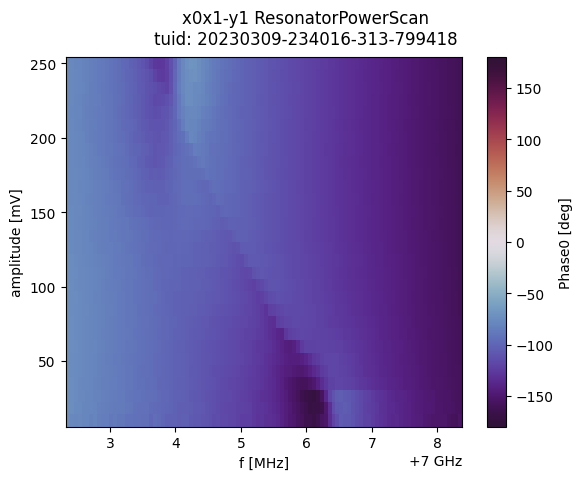

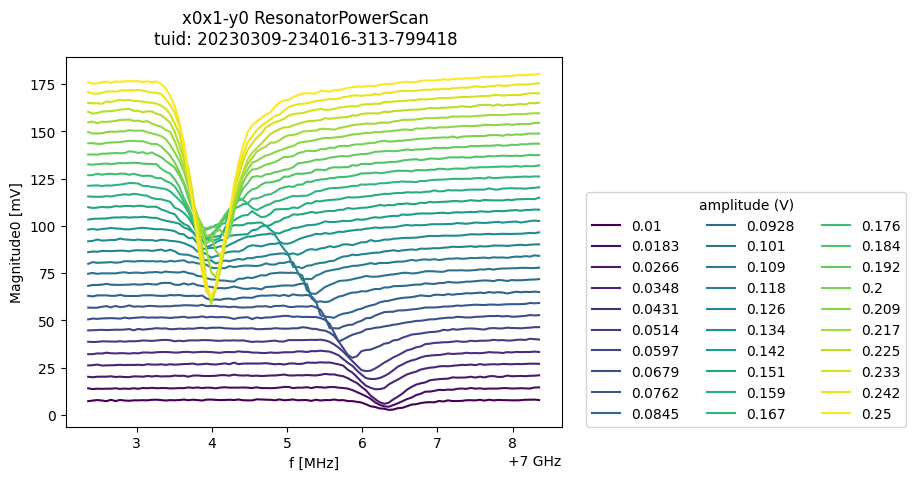

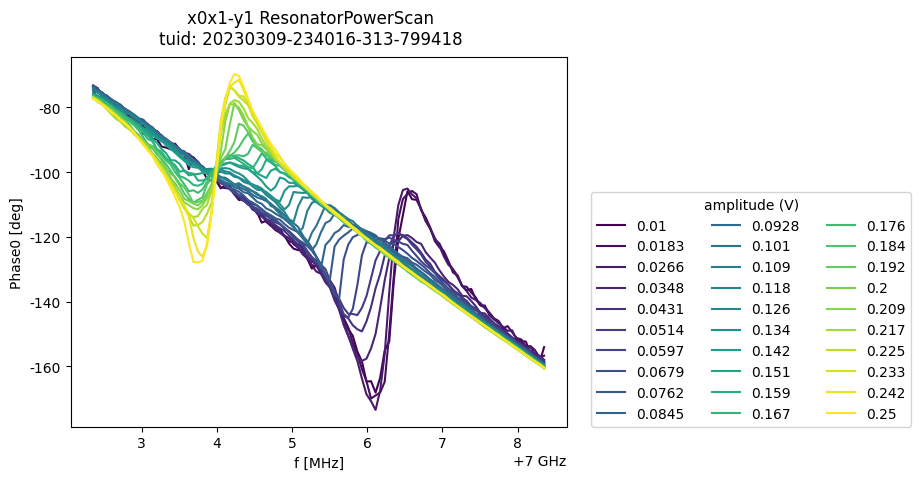

In [20]:
from quantify_core.analysis.base_analysis import Basic2DAnalysis

b2a = Basic2DAnalysis(tuid=punchout_ds.attrs["tuid"], dataset=punchout_ds)
b2a.run().display_figs_mpl()

## Qubit spectroscopy

In [21]:
def two_tone_spec_sched_nco(
    qubit_name: str,
    spec_pulse_amp: float,
    spec_pulse_duration: float,
    spec_pulse_port: str,
    spec_pulse_clock: str,
    spec_pulse_frequencies: np.ndarray,
    repetitions: int = 1,
) -> Schedule:
    """
    Generate a batched schedule for performing fast two-tone spectroscopy.

    Using the `SetClockFrequency` operation for doing an NCO sweep.

    Parameters
    ----------
    qubit_name
        qubit that should be used.
    spec_pulse_amp
        Amplitude of the spectroscopy pulse in Volt.
    spec_pulse_duration
        Duration of the spectroscopy pulse in seconds.
    spec_pulse_port
        Location on the device where the spectroscopy pulse should be applied.
    spec_pulse_clock
        Reference clock used to track the spectroscopy frequency.
    spec_pulse_frequencies
        Sample frequencies for the spectroscopy pulse in Hertz.
    repetitions
        The amount of times the Schedule will be repeated.

    """
    sched = Schedule("two-tone", repetitions)
    sched.add_resource(ClockResource(name=spec_pulse_clock, freq=spec_pulse_frequencies.flat[0]))

    for acq_idx, spec_pulse_freq in enumerate(spec_pulse_frequencies):
        sched.add(Reset(qubit_name))
        sched.add(SetClockFrequency(clock=spec_pulse_clock, clock_freq_new=spec_pulse_freq))
        sched.add(
            SquarePulse(
                duration=spec_pulse_duration,
                amp=spec_pulse_amp,
                port=spec_pulse_port,
                clock=spec_pulse_clock,
            )
        )
        sched.add(Measure(qubit_name, acq_index=acq_idx))

    return sched

In [22]:
freq = ManualParameter(name="freq", unit="Hz", label="Frequency")
freq.batched = True

qubit_spec_sched_kwargs = dict(
    qubit_name=qubit.name,
    spec_pulse_frequencies=freq,
    spec_pulse_amp=1.0,
    spec_pulse_duration=48e-6,
    spec_pulse_port=qubit.ports.microwave(),
    spec_pulse_clock=qubit.name + ".01",
)

gettable = ScheduleGettable(
    quantum_device,
    schedule_function=two_tone_spec_sched_nco,
    schedule_kwargs=qubit_spec_sched_kwargs,
    real_imag=False,
    batched=True,
)

meas_ctrl.gettables(gettable)

In [23]:

quantum_device.cfg_sched_repetitions(300)
center = 6.1e9
frequency_setpoints = np.linspace(center - 20e6, center + 20e6, 300)
meas_ctrl.settables(freq)
meas_ctrl.setpoints(frequency_setpoints)

qs_ds = meas_ctrl.run("Two-tone")
qs_ds

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 freq 
Batch size limit: 300



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

<xarray.Dataset>
Dimensions:  (dim_0: 300)
Coordinates:
    x0       (dim_0) float64 6.08e+09 6.08e+09 6.08e+09 ... 6.12e+09 6.12e+09
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    y1       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    tuid:                             20240422-183625-680-0a2f22
    name:                             Two-tone
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

In [24]:
# If on dummy, override with old data for analysis
if cluster_ip is None:
    qs_ds = dh.load_dataset(tuid="20230523-175716-868-8746ad")

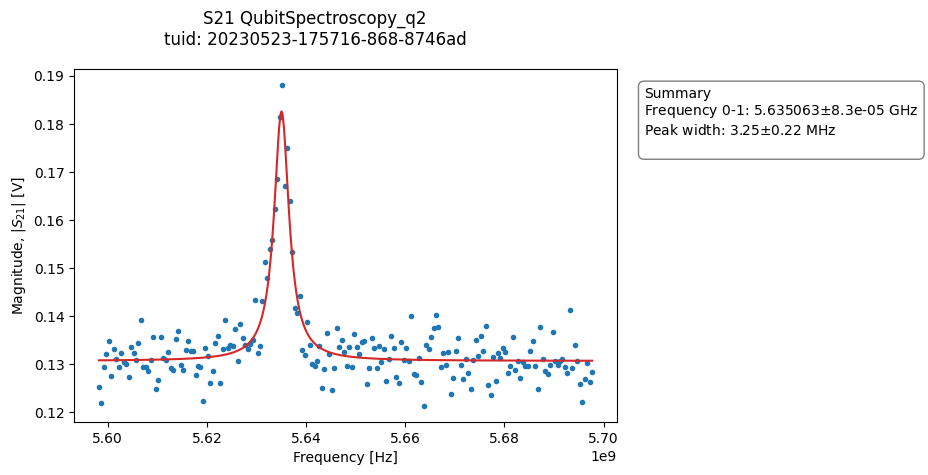

In [25]:
qs_analysis = QubitSpectroscopyAnalysis(tuid=qs_ds.attrs["tuid"], dataset=qs_ds)
qs_analysis.run().display_figs_mpl()

In [26]:
qubit.clock_freqs.f01(qs_analysis.quantities_of_interest["frequency_01"].nominal_value)

## Rabi oscillations

In [27]:
pulse_amp = ManualParameter(name="pulse_amplitude", unit="V", label="amplitude")
pulse_amp.batched = True

rabi_sched_kwargs = {
    "pulse_amp": pulse_amp,
    "pulse_duration": qubit.rxy.duration(),
    "frequency": qubit.clock_freqs.f01(),
    "qubit": qubit.name,
}

gettable = ScheduleGettable(
    quantum_device,
    schedule_function=rabi_sched,
    schedule_kwargs=rabi_sched_kwargs,
    batched=True,
)

meas_ctrl.gettables(gettable)

In [28]:

quantum_device.cfg_sched_repetitions(400)

amplitude_setpoints = np.linspace(-0.14, 0.14, 200)

meas_ctrl.settables(pulse_amp)
meas_ctrl.setpoints(amplitude_setpoints)

rabi_ds = meas_ctrl.run("Rabi")
rabi_ds

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 pulse_amplitude 
Batch size limit: 200



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

<xarray.Dataset>
Dimensions:  (dim_0: 200)
Coordinates:
    x0       (dim_0) float64 -0.14 -0.1386 -0.1372 ... 0.1372 0.1386 0.14
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    y1       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    tuid:                             20240422-183627-134-072b23
    name:                             Rabi
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

In [29]:
# If on dummy, override with old data for analysis
if cluster_ip is None:
    rabi_ds = dh.load_dataset(tuid="20230508-125501-555-fe2542")

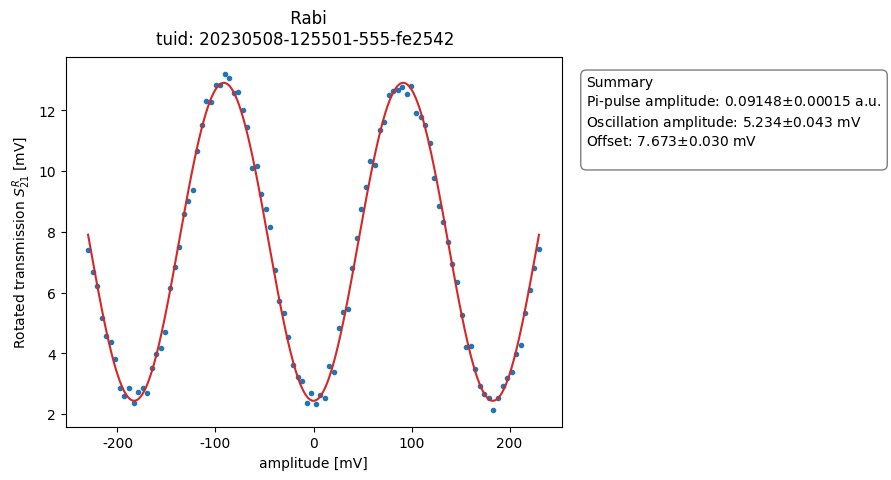

In [30]:
rabi_analysis = RabiAnalysis(tuid=rabi_ds.attrs["tuid"], dataset=rabi_ds)
rabi_analysis.run().display_figs_mpl()

In [31]:
qubit.rxy.amp180(rabi_analysis.quantities_of_interest["Pi-pulse amplitude"].nominal_value)

## Ramsey oscillations

In [32]:
tau = ManualParameter(name="tau", unit="s", label="Time")
tau.batched = True

ramsey_sched_kwargs = {
    "qubit": qubit.name,
    "times": tau,
    "artificial_detuning": 0.0,
}

gettable = ScheduleGettable(
    quantum_device,
    schedule_function=ramsey_sched,
    schedule_kwargs=ramsey_sched_kwargs,
    real_imag=False,
    batched=True,
)
meas_ctrl.gettables(gettable)

In [33]:
tau_setpoints = np.arange(20e-9, 4e-6, 40e-9)

meas_ctrl.settables(tau)
meas_ctrl.setpoints(tau_setpoints)

quantum_device.cfg_sched_repetitions(500)
ramsey_ds = meas_ctrl.run("ramsey")
ramsey_ds

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau 
Batch size limit: 100



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

<xarray.Dataset>
Dimensions:  (dim_0: 100)
Coordinates:
    x0       (dim_0) float64 2e-08 6e-08 1e-07 ... 3.9e-06 3.94e-06 3.98e-06
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    y1       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    tuid:                             20240422-183628-346-0e9e30
    name:                             ramsey
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

In [34]:
# If on dummy, override with old data for analysis
if cluster_ip is None:
    ramsey_ds = dh.load_dataset(tuid="20230523-123745-377-d21d2c")

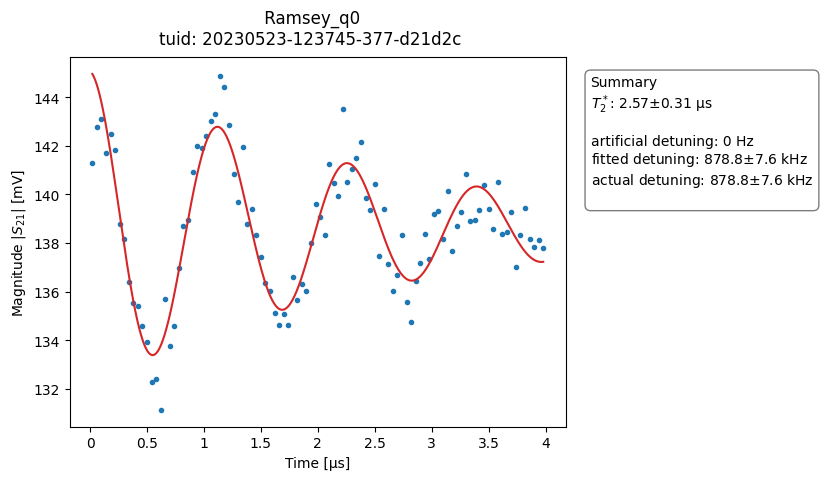

In [35]:
ramsey_analysis = RamseyAnalysis(tuid=ramsey_ds.attrs["tuid"], dataset=ramsey_ds)
ramsey_analysis.run(
    artificial_detuning=ramsey_sched_kwargs["artificial_detuning"]
).display_figs_mpl()

In [36]:
qubit.clock_freqs.f01(
    qubit.clock_freqs.f01() + ramsey_analysis.quantities_of_interest["detuning"].nominal_value
)

## T1

In [37]:
tau = ManualParameter(name="tau_delay", unit="s", label="Delay")
tau.batched = True

t1_sched_kwargs = {"qubit": qubit.name, "times": tau}

gettable = ScheduleGettable(
    quantum_device,
    schedule_function=t1_sched,
    schedule_kwargs=t1_sched_kwargs,
    real_imag=False,
    batched=True,
)
meas_ctrl.gettables(gettable)

In [38]:
delay_setpoints = np.arange(40e-9, 200e-6, 500e-9)

meas_ctrl.settables(tau)
meas_ctrl.setpoints(delay_setpoints)

quantum_device.cfg_sched_repetitions(300)
t1_ds = meas_ctrl.run("T1 experiment")
t1_ds

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau_delay 
Batch size limit: 400



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

<xarray.Dataset>
Dimensions:  (dim_0: 400)
Coordinates:
    x0       (dim_0) float64 4e-08 5.4e-07 1.04e-06 ... 0.000199 0.0001995
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    y1       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    tuid:                             20240422-183629-562-8de53e
    name:                             T1 experiment
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

In [39]:
# If on dummy, override with old data for analysis
if cluster_ip is None:
    t1_ds = dh.load_dataset(tuid="20230309-234522-242-193e69")

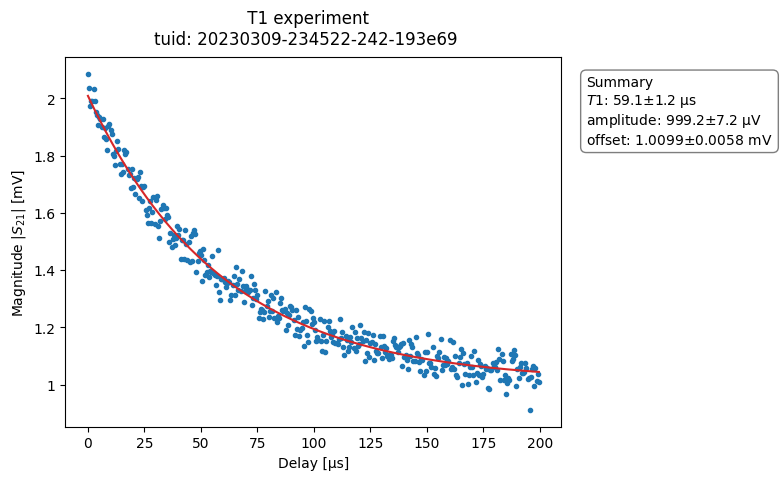

In [40]:
t1_analysis = T1Analysis(dataset=t1_ds)
t1_analysis.run().display_figs_mpl()

## Sweetspot experiments

A flux-tunable qubit is a qubit where the qubit frequency can be altered by changing a magnetic field piercing the circuit.

Here we consider two 2D experiments for finding the flux sweetspot of a flux-tunable qubit. The experiments are:
1. Resonator-flux spectroscopy
    - Used to find the flux sweetspot when the qubit is in $|0\rangle$.
    - Resonator spectroscopy as a function of applied external flux.
2. Qubit-flux spectroscopy (a.k.a two-tone)
    - Used to find the flux sweetspot when the qubit is excited.
    - Qubit spectroscopy as a function of applied external flux.

### Resonator-flux spectroscopy

In [41]:
freq = ManualParameter(name="freq", unit="Hz", label="Frequency")
freq.batched = True
freq.batch_size = 100

spec_sched_kwargs = dict(
    pulse_amp=0.25 / 6,
    pulse_duration=2e-6,
    frequencies=freq,
    acquisition_delay=80e-9,
    integration_time=2e-6,
    init_duration=200e-6,
    port=qubit.ports.readout(),
    clock=qubit.name + ".ro",
)
gettable = ScheduleGettable(
    quantum_device,
    schedule_function=heterodyne_spec_sched_nco,
    schedule_kwargs=spec_sched_kwargs,
    real_imag=False,
    batched=True,
)

meas_ctrl.gettables(gettable)

In [42]:

quantum_device.cfg_sched_repetitions(80)
center = 7.7e9
frequency_setpoints = np.linspace(center - 20e6, center + 20e6, 300)

meas_ctrl.settables([freq, flux_settable])
meas_ctrl.setpoints_grid((frequency_setpoints, np.linspace(0, 1, 3)))

rfs_ds = meas_ctrl.run("resonator flux spectroscopy")
rfs_ds

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 out0_offset 
Batched settable(s):
	 freq 
Batch size limit: 100



c:\Users\axela\miniconda3\envs\aps\lib\site-packages\quantify_scheduler\backends\circuit_to_device.py:379: RuntimeWarning: Clock 'qubit.ro' has conflicting frequency definitions: 7680000000.0 Hz in the schedule and 7902650075.61745 Hz in the device config. The clock is set to '7680000000.0'. Ensure the schedule clock resource matches the device config clock frequency or set the clock frequency in the device config to np.NaN to omit this warning.
  warnings.warn(


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

c:\Users\axela\miniconda3\envs\aps\lib\site-packages\quantify_scheduler\backends\circuit_to_device.py:379: RuntimeWarning: Clock 'qubit.ro' has conflicting frequency definitions: 7693377926.421405 Hz in the schedule and 7902650075.61745 Hz in the device config. The clock is set to '7693377926.421405'. Ensure the schedule clock resource matches the device config clock frequency or set the clock frequency in the device config to np.NaN to omit this warning.
  warnings.warn(
c:\Users\axela\miniconda3\envs\aps\lib\site-packages\quantify_scheduler\backends\circuit_to_device.py:379: RuntimeWarning: Clock 'qubit.ro' has conflicting frequency definitions: 7706755852.84281 Hz in the schedule and 7902650075.61745 Hz in the device config. The clock is set to '7706755852.84281'. Ensure the schedule clock resource matches the device config clock frequency or set the clock frequency in the device config to np.NaN to omit this warning.
  warnings.warn(
c:\Users\axela\miniconda3\envs\aps\lib\site-pack

<xarray.Dataset>
Dimensions:  (dim_0: 900)
Coordinates:
    x0       (dim_0) float64 7.68e+09 7.68e+09 7.68e+09 ... 7.72e+09 7.72e+09
    x1       (dim_0) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    y1       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    tuid:                             20240422-183630-992-a7a18b
    name:                             resonator flux spectroscopy
    grid_2d:                          True
    grid_2d_uniformly_spaced:         True
    1d_2_settables_uniformly_spaced:  False
    xlen:                             300
    ylen:                             3

In [43]:
# If on dummy, override with old data for analysis
if cluster_ip is None:
    rfs_ds = dh.load_dataset(tuid="20230308-235659-059-cf471e")

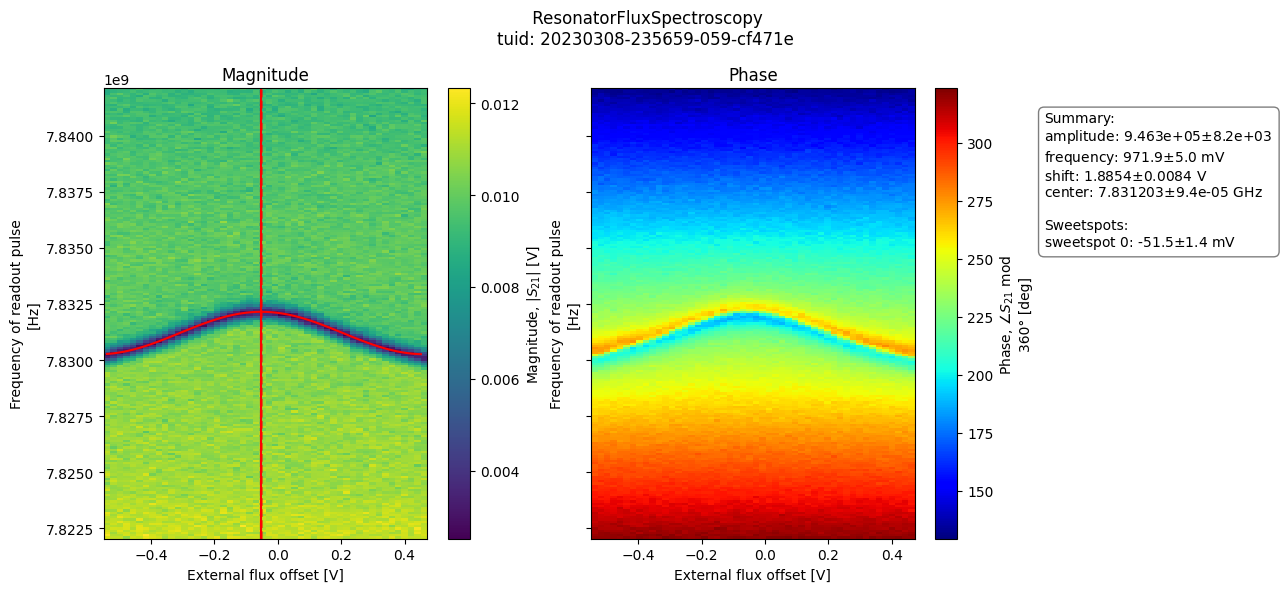

In [44]:
rfs_analysis = ResonatorFluxSpectroscopyAnalysis(tuid=rfs_ds.attrs["tuid"], dataset=rfs_ds)
rfs_analysis.run().display_figs_mpl()

In [45]:
# Update the flux sweetspot
flux_settable(rfs_analysis.quantities_of_interest["sweetspot_0"].nominal_value)

### Qubit-flux spectroscopy

In [46]:
freq = ManualParameter(name="freq", unit="Hz", label="Frequency")
freq.batched = True

qubit_spec_sched_kwargs = dict(
    qubit_name=qubit.name,
    spec_pulse_frequencies=freq,
    spec_pulse_amp=0.25,
    spec_pulse_duration=48e-6,
    spec_pulse_port=qubit.ports.microwave(),
    spec_pulse_clock=qubit.name + ".01",
)

gettable = ScheduleGettable(
    quantum_device,
    schedule_function=two_tone_spec_sched_nco,
    schedule_kwargs=qubit_spec_sched_kwargs,
    real_imag=False,
    batched=True,
)

meas_ctrl.gettables(gettable)

In [47]:

quantum_device.cfg_sched_repetitions(400)
center = qubit.clock_freqs.f01()
frequency_setpoints = np.linspace(center - 20e6, center + 20e6, 300)
meas_ctrl.settables([freq, flux_settable])
meas_ctrl.setpoints_grid((frequency_setpoints, np.linspace(0, 1, 3)))

qfs_ds = meas_ctrl.run("flux two-tone")
qfs_ds

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 out0_offset 
Batched settable(s):
	 freq 
Batch size limit: 900



c:\Users\axela\miniconda3\envs\aps\lib\site-packages\quantify_scheduler\backends\circuit_to_device.py:379: RuntimeWarning: Clock 'qubit.01' has conflicting frequency definitions: 5615941781.889758 Hz in the schedule and 5635941781.889758 Hz in the device config. The clock is set to '5615941781.889758'. Ensure the schedule clock resource matches the device config clock frequency or set the clock frequency in the device config to np.NaN to omit this warning.
  warnings.warn(


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

c:\Users\axela\miniconda3\envs\aps\lib\site-packages\quantify_scheduler\backends\circuit_to_device.py:379: RuntimeWarning: Clock 'qubit.01' has conflicting frequency definitions: 5615941781.889758 Hz in the schedule and 5635941781.889758 Hz in the device config. The clock is set to '5615941781.889758'. Ensure the schedule clock resource matches the device config clock frequency or set the clock frequency in the device config to np.NaN to omit this warning.
  warnings.warn(
c:\Users\axela\miniconda3\envs\aps\lib\site-packages\quantify_scheduler\backends\circuit_to_device.py:379: RuntimeWarning: Clock 'qubit.01' has conflicting frequency definitions: 5615941781.889758 Hz in the schedule and 5635941781.889758 Hz in the device config. The clock is set to '5615941781.889758'. Ensure the schedule clock resource matches the device config clock frequency or set the clock frequency in the device config to np.NaN to omit this warning.
  warnings.warn(


<xarray.Dataset>
Dimensions:  (dim_0: 900)
Coordinates:
    x0       (dim_0) float64 5.616e+09 5.616e+09 ... 5.656e+09 5.656e+09
    x1       (dim_0) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    y1       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    tuid:                             20240422-183635-179-c7a7b7
    name:                             flux two-tone
    grid_2d:                          True
    grid_2d_uniformly_spaced:         True
    1d_2_settables_uniformly_spaced:  False
    xlen:                             300
    ylen:                             3

In [48]:
# If on dummy, override with old data for analysis
if cluster_ip is None:
    qfs_ds = dh.load_dataset(tuid="20230309-235354-353-9c94c5")

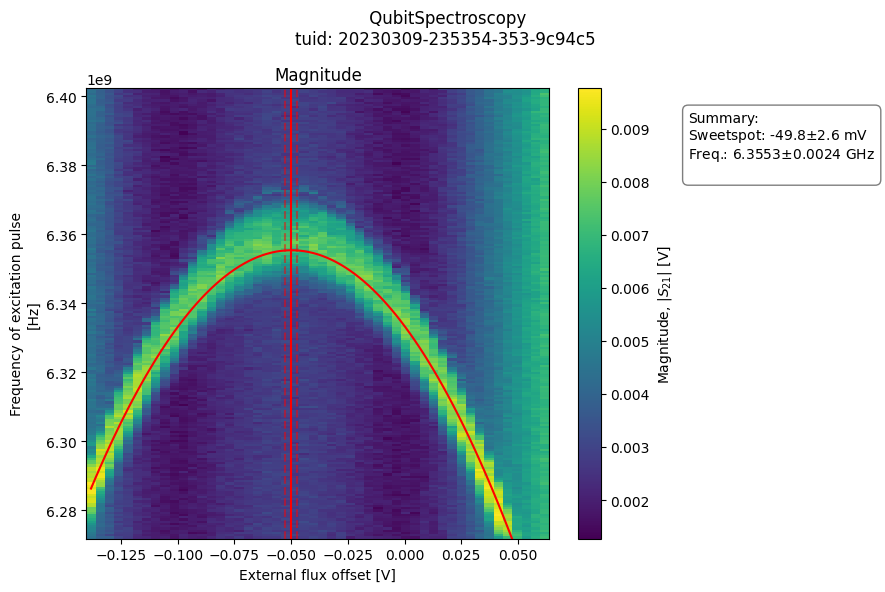

In [49]:
qfs_analysis = QubitFluxSpectroscopyAnalysis(tuid=qfs_ds.attrs["tuid"], dataset=qfs_ds)
qfs_analysis.run().display_figs_mpl()

In [50]:
# Update the flux sweetspot
flux_settable(qfs_analysis.quantities_of_interest["sweetspot"].nominal_value)